# Neural Network

In [17]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split, Subset
import matplotlib.pyplot as plt
from tqdm import tqdm

## Parameters

In [18]:
input_dim = 768 # Do not change this value

layer_configs = {
    '3_layers': [input_dim, 512, 256, 1],
    '4_layers': [input_dim, 512, 256, 128, 1],
    '5_layers_512': [input_dim, 512, 256, 128, 64, 1],
    '5_layers_256': [input_dim, 256, 128, 64, 32, 1]
} 
layer_sizes = layer_configs['3_layers'] # Choose the layer configuration you want to use, or add your own configuration

cutoff_value = 50 # Cutoff target value for the dataset. Test sets will be cut anyways.

## Data Preprocessing

In [19]:
# Load the uploaded Excel file
file_path = 'f:\\Projects\\project_ML-interconnect\\RhoLambda\\extracted-feature-best_rho_lam.csv'
data = pd.read_csv(file_path)
target_name = data.columns[-2]

# Display the first few rows of the dataset to understand its structure
data.head()

,0,1,2,3,4,5,6,7,8,9,...,760,761,762,763,764,765,766,767,best_rho_lam,id
0,-0.060153,-0.365352,0.039778,0.210376,0.045779,0.044059,-0.230032,0.440505,-0.060797,0.033143,...,0.254316,0.240958,0.293221,0.069077,-0.181982,0.057156,-0.028961,0.066357,14.22,mp-9999
1,0.041623,-0.544182,0.042039,-0.100868,-0.052467,0.020017,-0.003392,0.474122,-0.035656,-0.046436,...,0.057913,0.288004,0.020007,-0.006053,0.173469,-0.107859,0.159609,0.367483,26.26,mp-999576
2,0.142946,-0.350995,-0.001650,-0.164363,-0.100563,-0.021269,-0.025037,-0.227148,0.031124,0.021148,...,0.048725,0.091218,0.121174,0.324637,1.003774,-0.214007,0.098877,-0.314284,16.36,mp-999544
3,-0.004096,-0.188049,-0.065996,-0.032705,-0.199742,-0.005587,-0.125104,0.672775,-0.195106,-0.010469,...,0.157616,0.385989,-0.056726,0.016120,-0.085792,-0.136867,-0.167848,0.045125,8.03,mp-999502
4,0.008891,0.465420,-0.002653,0.045225,-0.052654,-0.044856,-0.025235,0.700613,-0.050401,-0.030085,...,-0.166666,0.200078,0.013963,0.235803,0.056954,-0.194386,-0.203228,-0.081465,6.77,mp-999376


## Split and Cutoff

In [20]:
def data_cutter(dataset, cutoff_value):
    # Get the indices of the dataset
    indices = dataset.indices if isinstance(dataset, Subset) else range(len(dataset))

    # Filter indices based on the cutoff value for the target variable
    filtered_indices = [i for i in indices if dataset.dataset[i][1] <= cutoff_value]

    # Create a new Subset with the filtered indices
    return Subset(dataset.dataset, filtered_indices)

def data_splitter(train_dataset, val_dataset, test_dataset, cutoff_value, all_cutoff=False):

    if not all_cutoff:
        test_dataset = data_cutter(test_dataset, cutoff_value)
    else:
        train_dataset = data_cutter(train_dataset, cutoff_value)
        val_dataset = data_cutter(val_dataset, cutoff_value)
        test_dataset = data_cutter(test_dataset, cutoff_value)

    # Create data loaders
    batch_size = 32
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_dataset, val_dataset, test_dataset, train_loader, val_loader, test_loader

## Dataset Validation

In [21]:
def plot_distribution(dataset, train_dataset, val_dataset, test_dataset):
    # Valiadte the distribution of the target variable in both the train and validation sets
    train_target = torch.cat([dataset[i][1] for i in train_dataset.indices])
    val_target = torch.cat([dataset[i][1] for i in val_dataset.indices])
    test_target = torch.cat([dataset[i][1] for i in test_dataset.indices])

    min_val = float(min(train_target.min(), val_target.min(), test_target.min()))
    # min_val = 250
    max_test_val = float(test_target.max())
    max_val = float(max(train_target.max(), val_target.max(), test_target.min()))
    print('Minimum and Maximum values of the target variable in Train, Validation and Test sets:', round(min_val, 2), round(max_val, 2))
    print('Maximum value of the target variable in Test set:', round(max_test_val, 2))

    plt.figure(figsize=(10, 5))
    plt.hist(train_target, bins=40, alpha=0.5, label='Train(left)',align='left', density=True, range=(min_val, max_val))
    plt.hist(val_target, bins=40, alpha=0.5, label='Validation(middle)',align='mid', density=True, range=(min_val, max_val))
    plt.hist(test_target, bins=40, alpha=0.5, label='Test(right)',align='right', density=True, range=(min_val, max_val))
    plt.xlabel('Target Variable')
    plt.ylabel('Frequency')
    plt.title('Distribution of Target Variable in Train, Validation and Test Sets')
    plt.legend()
    plt.show()

## Model

In [22]:
# Define the neural network model
class NNModel(nn.Module):
    def __init__(self, layer_sizes):
        super(NNModel, self).__init__()
        layers = []
        for i in range(len(layer_sizes) - 1):
            layers.append(nn.Linear(layer_sizes[i], layer_sizes[i + 1]))
            if i < len(layer_sizes) - 2:
                layers.append(nn.ReLU())
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [23]:
def instantiate_model(dataset, train_dataset, val_dataset, test_dataset, layer_sizes, cutoff_value, cutoff):
    
    train_dataset, val_dataset, test_dataset, train_loader, val_loader, test_loader = data_splitter(train_dataset, val_dataset, test_dataset, cutoff_value, cutoff)

    # If you want to see the distribution of the dataset, uncomment the following line
    # plot_distribution(dataset, train_dataset, val_dataset, test_dataset)

    # Instantiate the model, define loss function and optimizer
    model = NNModel(layer_sizes)
    criterion = nn.L1Loss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Training function with progress bar
    def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=100):
        train_loss_history = []
        val_loss_history = []

        for epoch in tqdm(range(num_epochs), desc='Training Progress', leave=False):
            model.train()
            train_loss = 0.0
            for inputs, targets in train_loader:
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                loss.backward()
                optimizer.step()
                train_loss += loss.item() * inputs.size(0)

            train_loss /= len(train_loader.dataset)
            train_loss_history.append(train_loss)

            # Validation phase
            model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for inputs, targets in val_loader:
                    outputs = model(inputs)
                    loss = criterion(outputs, targets)
                    val_loss += loss.item() * inputs.size(0)

            val_loss /= len(val_loader.dataset)
            val_loss_history.append(val_loss)

        return train_loss_history, val_loss_history

    # Train the model
    train_loss_history, val_loss_history = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=100)

    plt.figure(figsize=(12, 10))
    plt.plot(train_loss_history, label='Train Loss')
    plt.plot(val_loss_history, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (L1 Loss)')
    plt.title('Train and Validation Loss over Epochs')
    plt.legend()
    plt.show()

    # Evaluate the model on the test set and plot predictions vs actual values
    def evaluate_model(model, test_loader, criterion):
        model.eval()
        test_loss = 0.0
        predictions = []
        actuals = []
        with torch.no_grad():
            for inputs, targets in test_loader:
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                test_loss += loss.item() * inputs.size(0)
                predictions.extend(outputs.numpy().flatten())
                actuals.extend(targets.numpy().flatten())
                
        test_loss /= len(test_loader.dataset)

        
        csv_file =  'f:\\Projects\\project_ML-interconnect\\Result\\rholambda_epoch_50_layers_3-3\\prediction_results_test_set.csv'

        label = '3-3 Layers'

        data = pd.read_csv(csv_file)
        old_targets = data['target']
        old_predictions = data['prediction']
        
        # Plot predictions vs actual values
        plt.figure(figsize=(12, 10))
        plt.scatter(actuals, predictions, alpha=0.5, label='Current Model')
        plt.scatter(old_targets, old_predictions, alpha=0.5, label='3-3 Layers Model')
        plt.plot([min(min(actuals), min(old_targets)), max(max(actuals), max(old_targets))],
                [min(min(actuals), min(old_targets)), max(max(actuals), max(old_targets))],
                'r--', label='Perfect Prediction')
        plt.xlabel('Actual Values')
        plt.ylabel('Predicted Values') 
        plt.title('Predictions vs Actual Values on Test Set')
        plt.legend()
        plt.show()
        return test_loss

    return evaluate_model(model, test_loader, criterion)

## Cutoff validation (result: cutoff is necesessary)

-----No Cutoff-----


Training Progress:   0%|          | 0/100 [00:00<?, ?it/s]

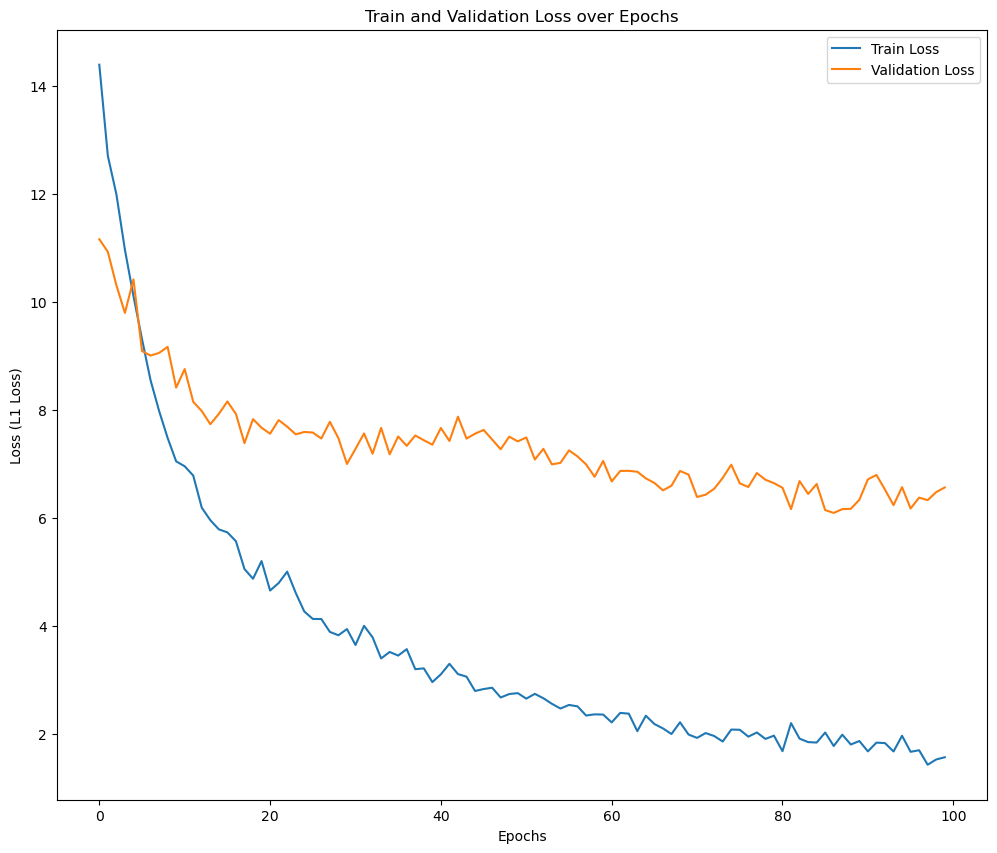

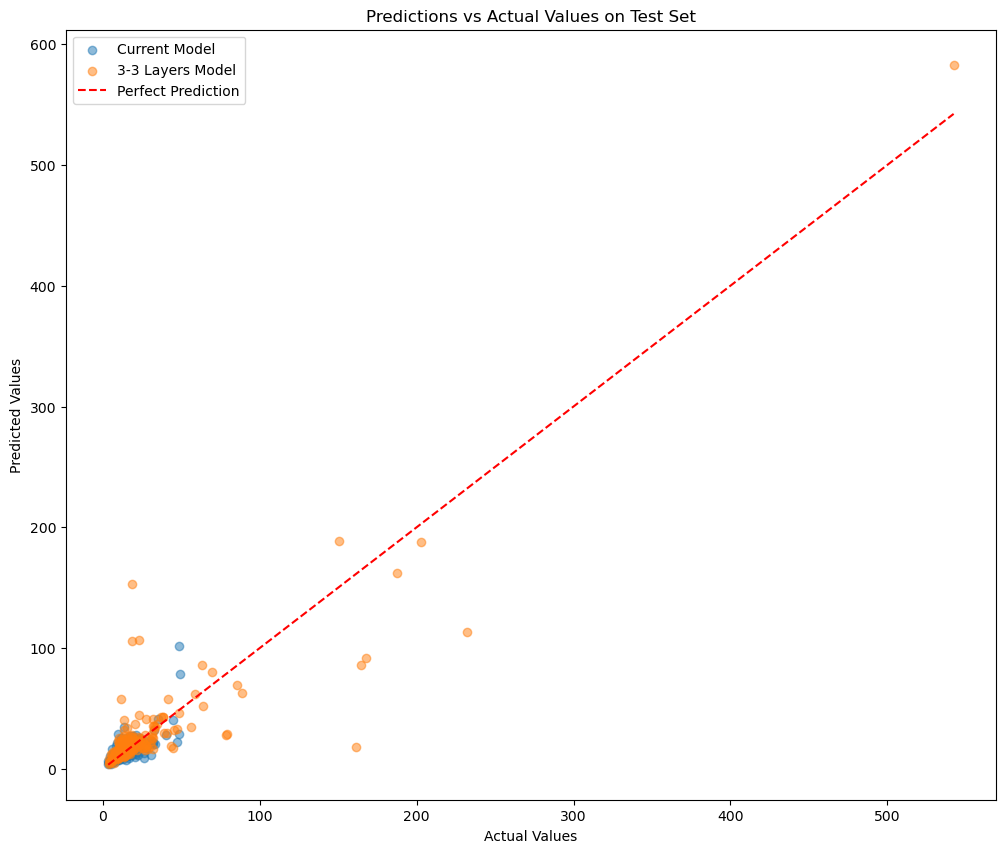

-----Cutoff at 50-----


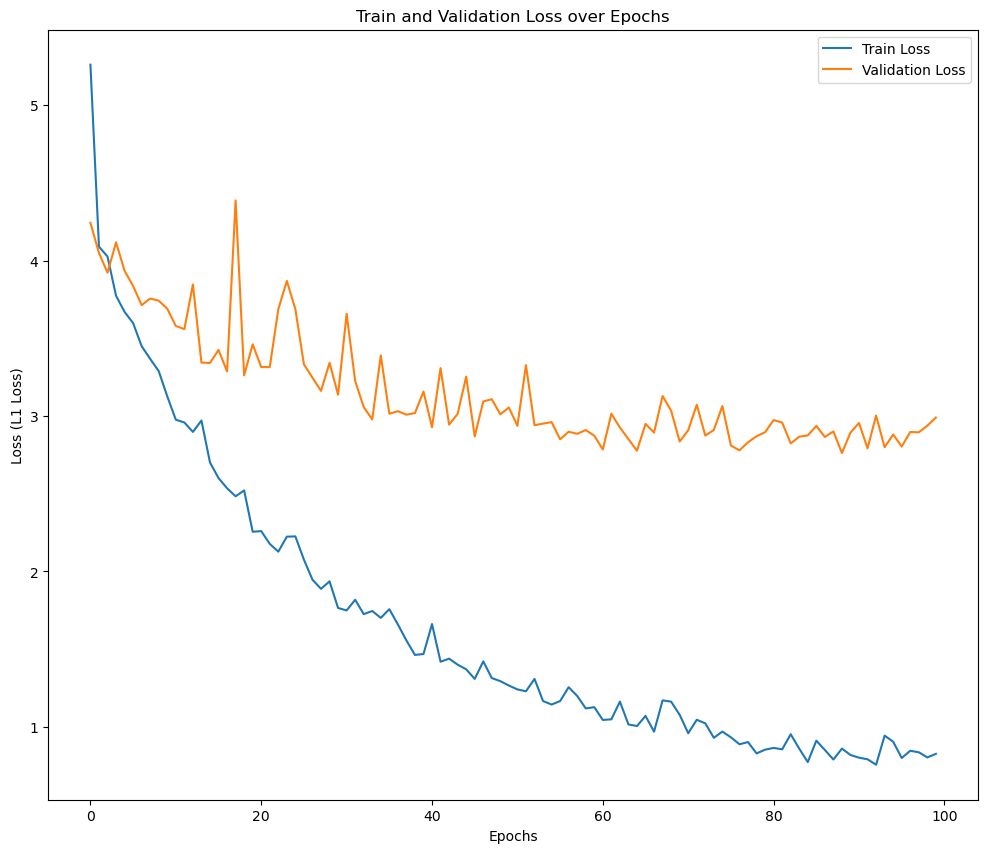

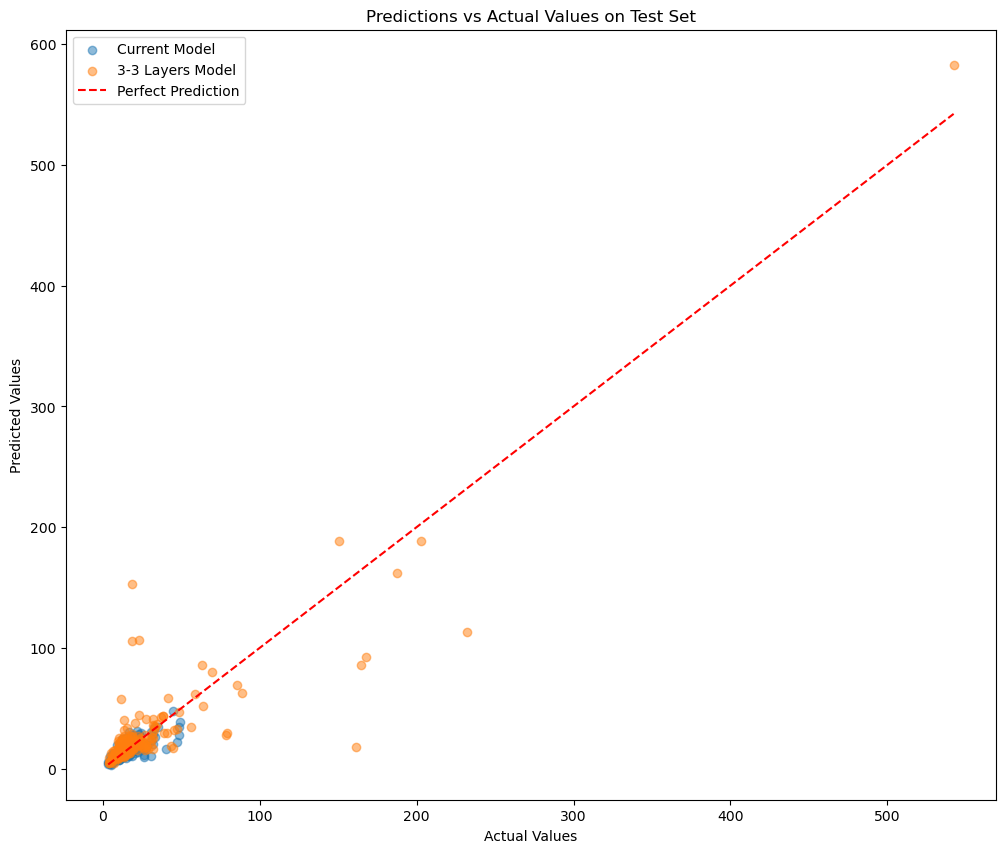

Cutoff at 50 is necessary.
3.197 2.8905
-----No Cutoff-----


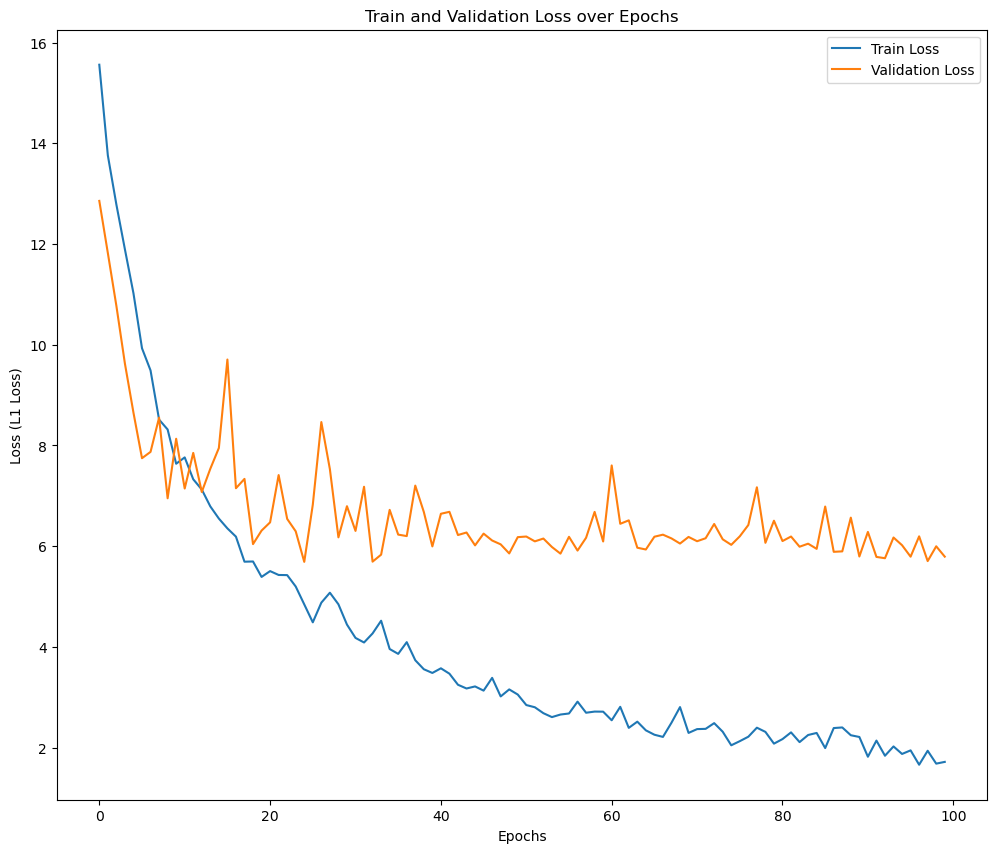

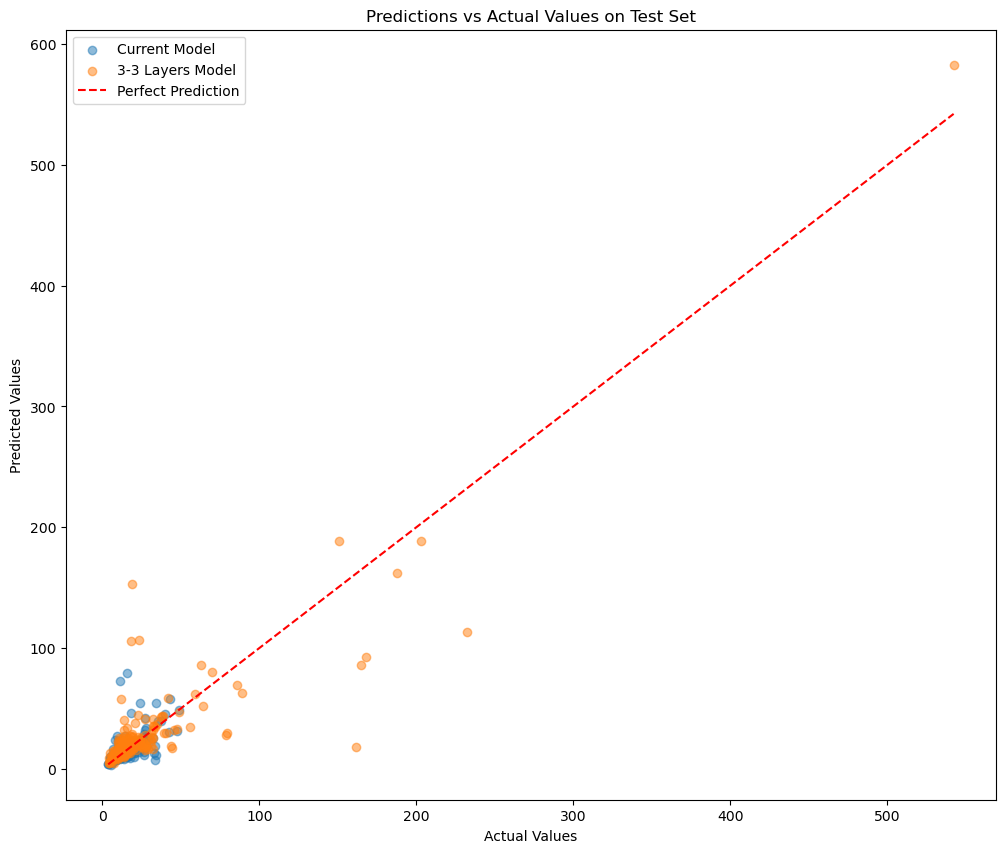

-----Cutoff at 50-----


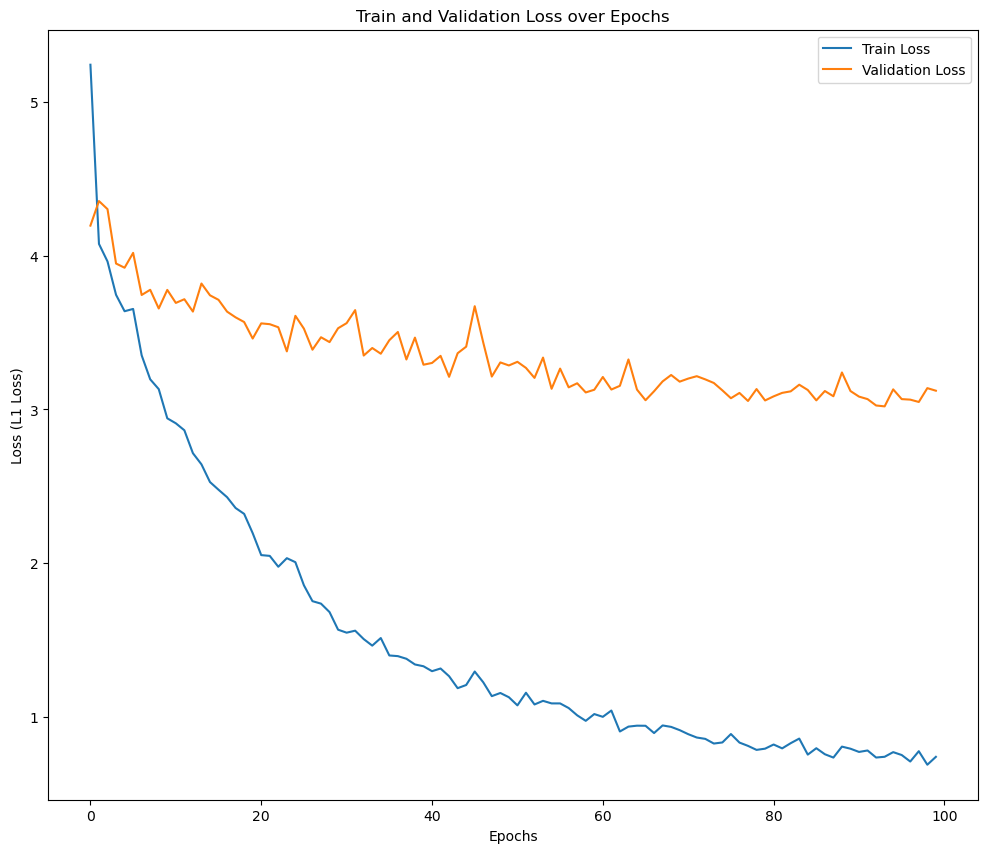

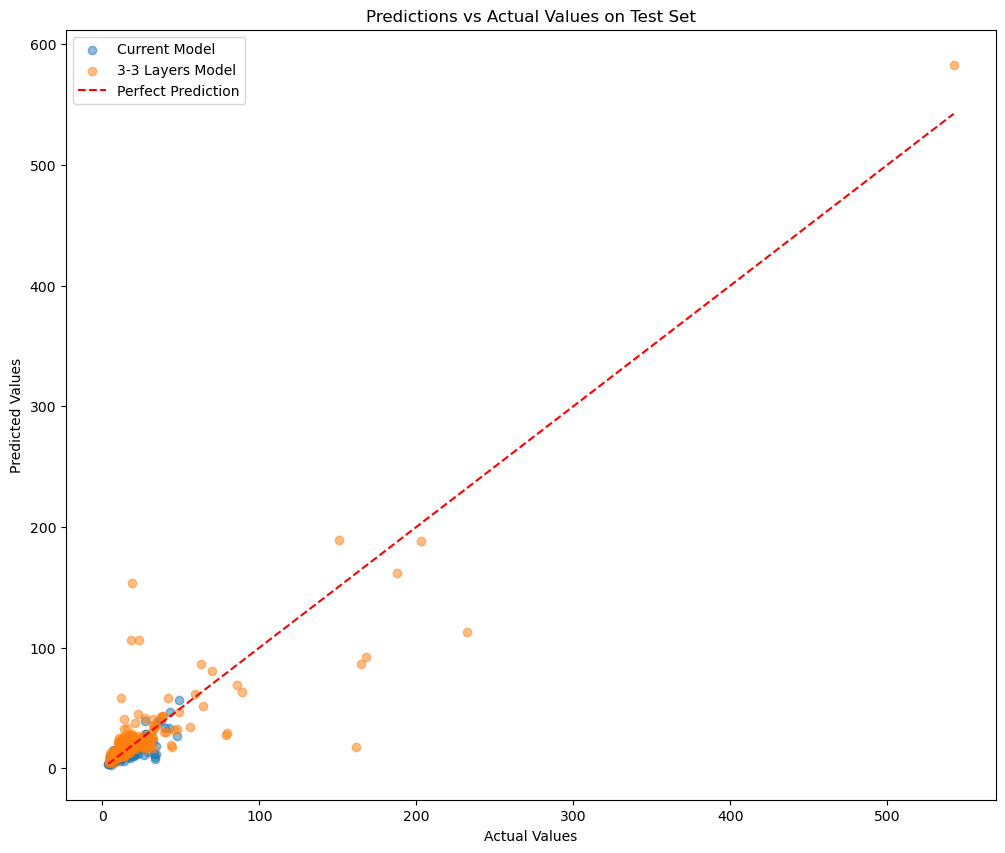

Cutoff at 50 is necessary.
3.6562 2.9104
-----No Cutoff-----


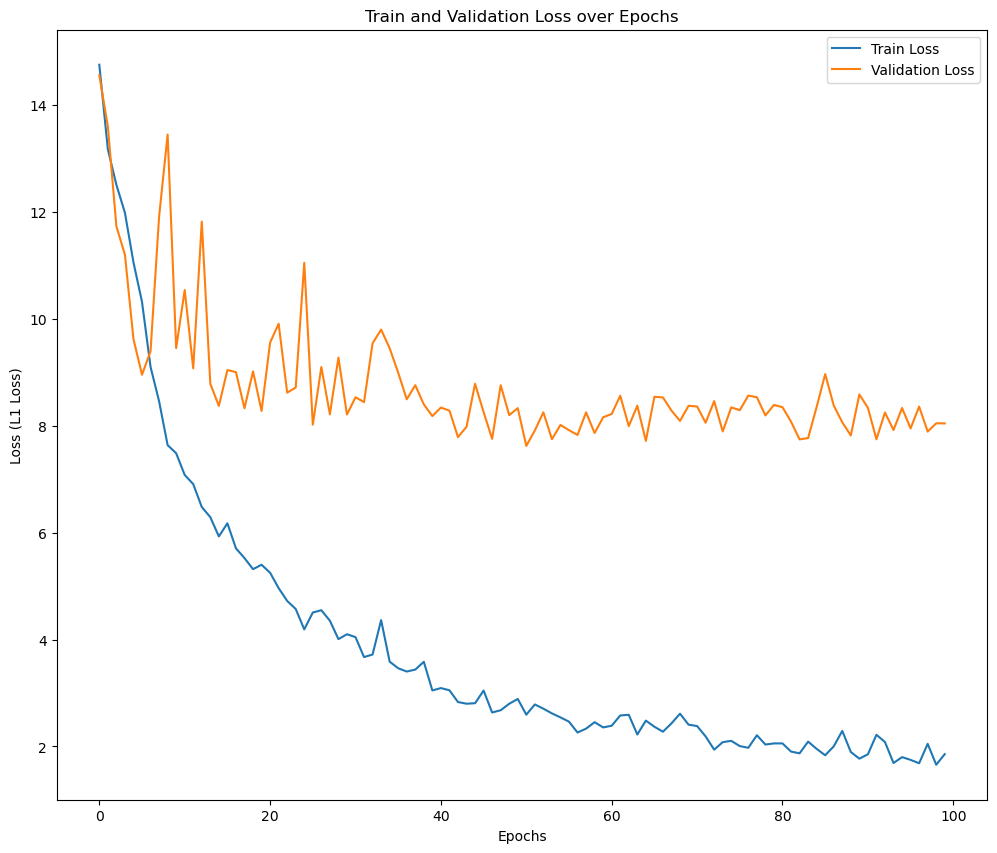

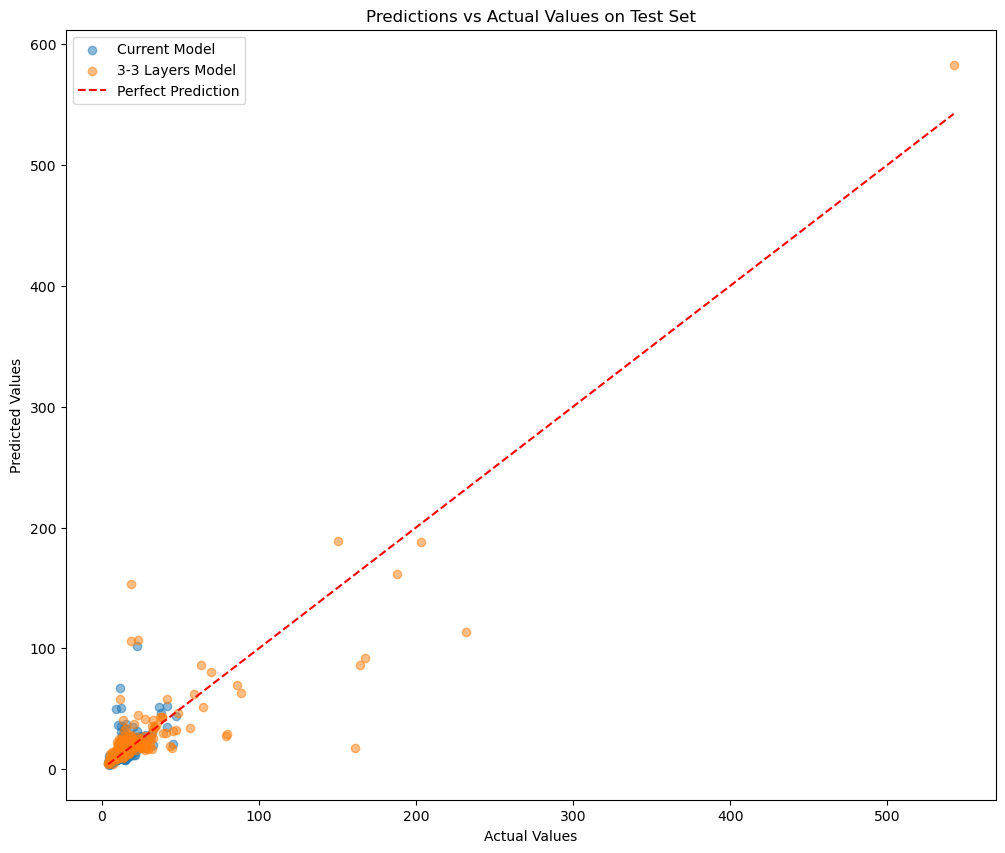

-----Cutoff at 50-----


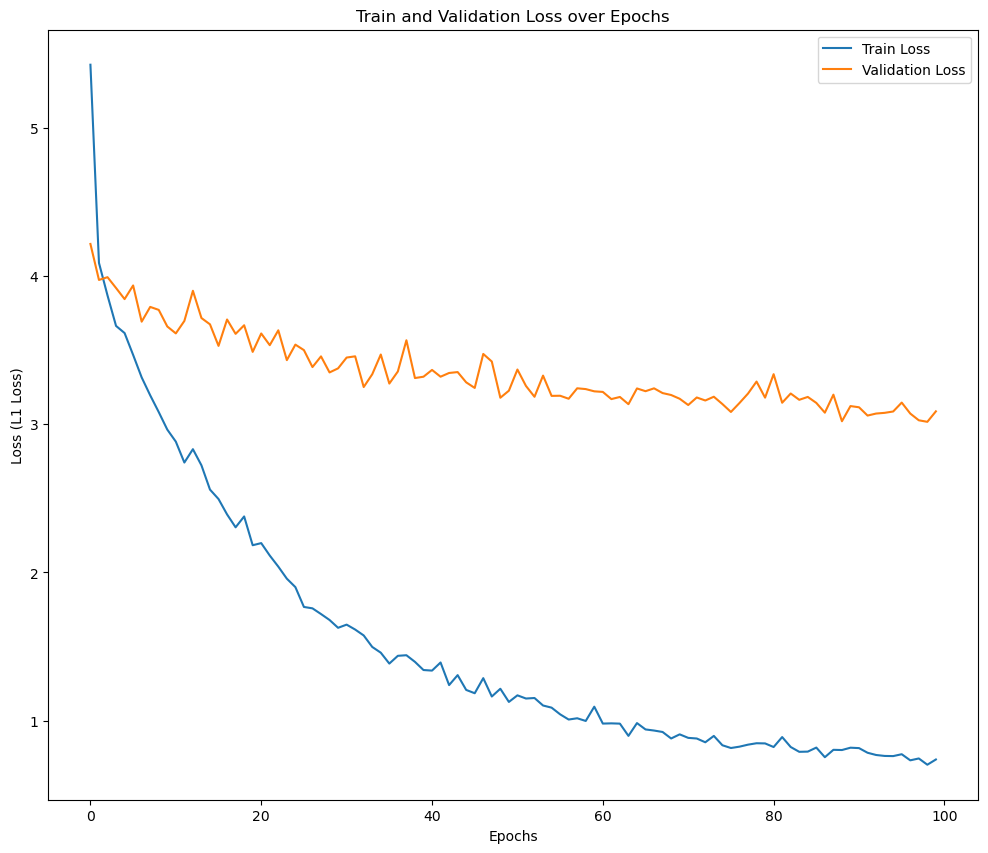

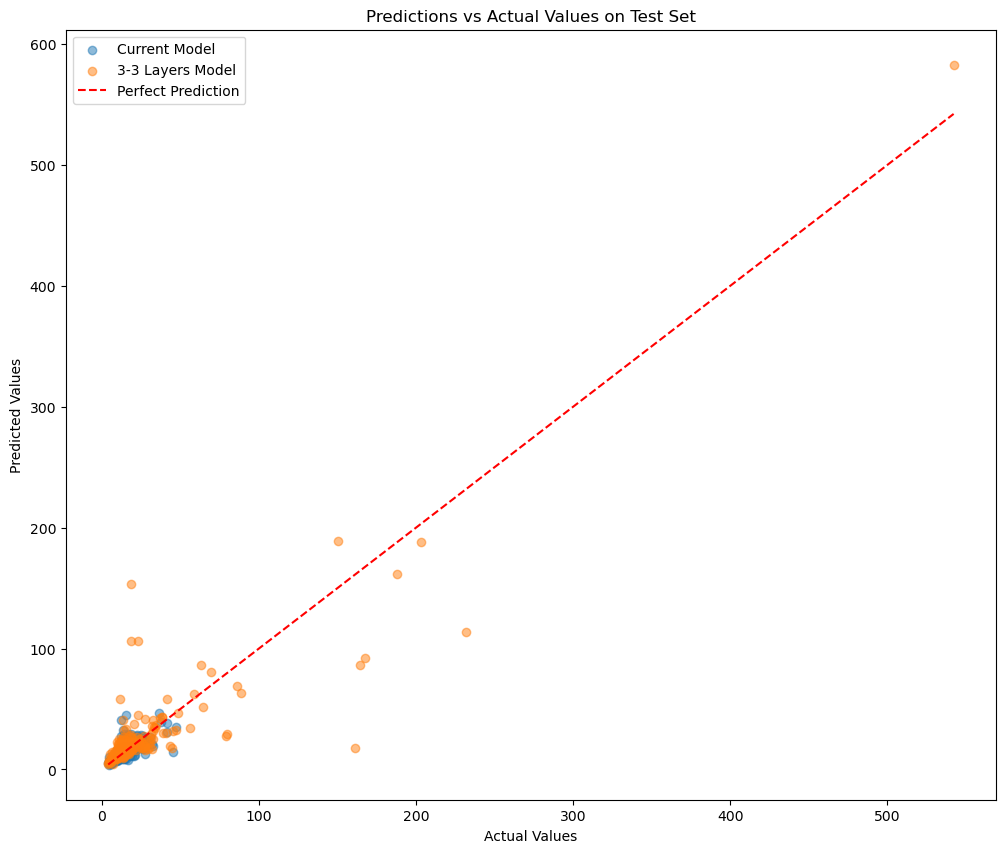

Cutoff at 50 is necessary.
3.6874 2.8824
-----No Cutoff-----


3 Tests Completed.
Result List: [True, True, True]


In [24]:
result_list = []
counter = 0

while True:
    try:
        # Prepare the dataset
        X = data.iloc[:, :-2].values  # all feature columns
        y = data.iloc[:, -2].values  # target column '2nd_rho_lam'

        # Convert to PyTorch tensors
        X_tensor = torch.tensor(X, dtype=torch.float32)
        y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(1)

        # Create a dataset and split it into training, validation, and testing sets
        dataset = TensorDataset(X_tensor, y_tensor)
        train_size = int(0.8 * len(dataset))
        val_size = int(0.1 * len(dataset))
        test_size = len(dataset) - train_size - val_size

        train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])
        
        print('-----No Cutoff-----')
        test_loss_no_cutoff = round(instantiate_model(dataset, train_dataset, val_dataset, test_dataset, layer_sizes, cutoff_value, cutoff = False), 4)
        print(f'-----Cutoff at {cutoff_value}-----')
        test_loss_with_cutoff = round(instantiate_model(dataset, train_dataset, val_dataset, test_dataset, layer_sizes, cutoff_value, cutoff = True), 4)
        # print('-----Configurations-----')
        # print('Layer sizes:', layer_sizes)
        # print('Cutoff value:', cutoff_value)
        # print('The test set is cut off for both cases, while in the second case training set and validation set are also cut off.')
        # print('-----Result-----')
        counter += 1
        if test_loss_no_cutoff <= test_loss_with_cutoff:
            print(f'Cutoff at {cutoff_value} is not necessary.')
            result_list.append(False)
            print(test_loss_no_cutoff, test_loss_with_cutoff)
        else:
            print(f'Cutoff at {cutoff_value} is necessary.')
            result_list.append(True)
            print(test_loss_no_cutoff, test_loss_with_cutoff)
    except KeyboardInterrupt:
        print(counter, 'Tests Completed.')
        print('Result List:', result_list)
        break

## Application

In [ ]:
result_path = f'F:\\Projects\\project_ML-interconnect\\RhoLambda\\{target_name}.csv'

# NOT IMPLEMENTED YET
# Features should be extracted first for new materials/poscars. Then a saved optimum model will be able to predict the target values.